1. 数据准备

In [1]:
from scipy import sparse
import networkx as nx
import numpy as np
import torch, pickle

# 数据加载和预处理
def load_and_preprocess_data(graph_pkl_path):
    # 从PKL加载图
    with open(graph_pkl_path, 'rb') as f:
        G = pickle.load(f)
    
    # 检查图结构
    print("是否为有向图:", isinstance(G, nx.DiGraph))
    sample_node = list(G.nodes())[0]
    print("必备属性是否存在？", 
      "bert_vector" in G.nodes[sample_node] and 
      "abstract" in G.nodes[sample_node] and
      "type" in G.nodes[sample_node] and
      "title" in G.nodes[sample_node])
    
    # 构建特征矩阵和邻接矩阵
    nodes = list(G.nodes())
    node_idx = {n: i for i, n in enumerate(nodes)}
    
    # 特征矩阵 (使用bert_vector)
    X = sparse.csr_matrix([G.nodes[n]['bert_vector'] for n in nodes], dtype=np.float32)
    
    # 构建有向邻接矩阵
    A_in = sparse.lil_matrix((len(nodes), len(nodes)))
    A_out = sparse.lil_matrix((len(nodes), len(nodes)))
    
    for u, v in G.edges():
        A_out[node_idx[u], node_idx[v]] = 1  # 出度
        A_in[node_idx[v], node_idx[u]] = 1    # 入度
    
    # 对称归一化
    def symmetric_normalize(mx):
        rowsum = np.array(mx.sum(1)).flatten()
        d_inv_sqrt = np.power(rowsum, -0.5)     # D^{-1/2}
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        return sparse.diags(d_inv_sqrt) @ mx @ sparse.diags(d_inv_sqrt)  # D^{-1/2}AD^{-1/2}
    
    # 归一化
    def normalize(mx): # 不用
        rowsum = np.array(mx.sum(1))
        r_inv = np.power(rowsum, -1).flatten() # D^{-1}
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = sparse.diags(r_inv)
        return r_mat_inv.dot(mx) # D^{-1}A
    
    #X = symmetric_normalize(X)
    A_in = symmetric_normalize(A_in)
    A_out = symmetric_normalize(A_out)
    
    # 转换为PyTorch稀疏张量
    def sparse_mx_to_torch_sparse(mx):
        mx = mx.tocoo().astype(np.float32)
        indices = torch.from_numpy(np.vstack((mx.row, mx.col)).astype(np.float64))
        values = torch.from_numpy(mx.data)
        shape = torch.Size(mx.shape)
        return torch.sparse_coo_tensor(indices, values, shape)
    
    X = torch.FloatTensor(np.array(X.todense()))
    A_in = sparse_mx_to_torch_sparse(A_in)
    A_out = sparse_mx_to_torch_sparse(A_out)
    
    return G, X, A_in, A_out, nodes, node_idx

In [2]:
G, X, A_in, A_out, nodes, node_idx = load_and_preprocess_data("bert_vectorized_network_2018.pkl")

是否为有向图: True
必备属性是否存在？ True


C:\Users\USER\AppData\Local\Temp\ipykernel_23636\2887401844.py:39: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5)     # D^{-1/2}


2. DGCN模型实现

In [7]:
with open("bert_vectorized_network_2018.pkl", 'rb') as f:
        G = pickle.load(f)

a = [n for n in G.nodes() if G.nodes()[n]['type']=='seed']
b = [n for n in G.nodes() if G.nodes()[n]['type']=='reference']
c = [n for n in G.nodes() if G.nodes()[n]['type']=='citation']
print(len(a), len(b), len(c), len(a)+len(b)+len(c))
print(len([n for n in G.edges()]))

47 336 746 1129
1097


In [3]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import math

# 图卷积层 (有向图版本)
class DirectedGraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(DirectedGraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # 分别处理入度和出度
        self.weight_in = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_out = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_self = Parameter(torch.FloatTensor(in_features, out_features))  # 新增自环权重
        
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features*2)) # 输出是2*out_features
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv_in = 1. / math.sqrt(self.weight_in.size(1))
        self.weight_in.data.uniform_(stdv_in, stdv_in)
        stdv_out = 1. / math.sqrt(self.weight_out.size(1))
        self.weight_out.data.uniform_(-stdv_out, stdv_out)
        if self.bias is not None:
            self.bias.data.uniform_(stdv_out, stdv_out)

    def forward(self, input, adj_in, adj_out):
        # 分别处理入度和出度
        support_in = torch.mm(input, self.weight_in)     # 入度邻居变换
        support_out = torch.mm(input, self.weight_out)   # 出度邻居变换
        support_self = torch.mm(input, self.weight_self) # 自环变换（核心修改）
        
        # 将单位矩阵转换为稀疏格式
        #device = adj_in.device
        #identity = torch.eye(adj_in.size(0)).to(device)
        #identity = identity.to_sparse()
        
        # 添加自环（现在都是稀疏矩阵相加）
        #adj_in_self = adj_in + identity
        #adj_out_self = adj_out + identity
        
        # 稀疏矩阵乘法
        output_in = torch.spmm(adj_in, support_in)
        output_out = torch.spmm(adj_out, support_out)

        # 自环处理（直接加自环变换结果）
        output_self = support_self  # 自环相当于单位矩阵乘法

        # 合并双向信息
        #output_self = torch.add(torch.spmm(identity, support_in),torch.spmm(identity, support_out))/2
        #output = output_in + output_out + output_self

        # 合并结果（拼接入度+自环 和 出度+自环）
        output = torch.cat(
            [output_in + output_self,  # 入度+自环
             output_out + output_self], # 出度+自环
            dim=1
        )  # 形状[N, out_features*2]
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output

# DGCN模型
class DGCN(nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout):
        super(DGCN, self).__init__()
        self.gc1 = DirectedGraphConvolution(nfeat, nhid)
        self.gc2 = DirectedGraphConvolution(nhid*2, nout)
        self.dropout = dropout

    def forward(self, x, adj_in, adj_out):
        x = F.relu(self.gc1(x, adj_in, adj_out))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj_in, adj_out)
        return x

3. 训练过程

In [4]:
import pandas as pd

# 训练函数 (无监督随机游走损失)
def train_dgcn(G, X, A_in, A_out, device='cpu', save_path='dgcn_model_2018.pth', save_log='dgcn_training_log_2018.csv'):
    model = DGCN(
        nfeat=X.size(1),
        nhid=256,
        nout=128,
        dropout=0.5
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # 随机游走损失
    def random_walk_loss(embeddings, adj_out, eps=1e-7):
        pos_pairs = torch.nonzero(adj_out.to_dense())
        src = pos_pairs[:, 0]
        tgt = pos_pairs[:, 1]
        
        # 计算相似度时添加温度系数
        pos_scores = torch.cosine_similarity(embeddings[src], embeddings[tgt], dim=1) / 0.1  # 温度系数
        neg_samples = torch.randint(len(embeddings), (len(src),))
        neg_scores = torch.cosine_similarity(embeddings[src], embeddings[neg_samples], dim=1) / 0.1
        
        # 稳定化计算
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + eps).mean()
        return loss
    
    # 初始化记录变量
    train_losses = []
    train_epochs = []

    # 训练循环
    for epoch in range(300):
        '''if epoch % 20 == 0:
            print("输入数据检查:")
            print(f"- X 包含NaN: {torch.isnan(X).any().item()}")
            print(f"- A_in 包含NaN: {torch.isnan(A_in.to_dense()).any().item()}")
            print(f"- A_out 包含NaN: {torch.isnan(A_out.to_dense()).any().item()}")
            print(f"- 初始权重包含NaN: {any(torch.isnan(p).any() for p in model.parameters())}")'''
        model.train()
        optimizer.zero_grad()
        
        embeddings = model(X.to(device), A_in.to(device), A_out.to(device))
        loss = random_walk_loss(embeddings, A_out.to(device))
        
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # 记录每个epoch的loss
        train_losses.append(loss.item())
        train_epochs.append(epoch)
        
        if epoch == 0:
            print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")
        elif (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")

    # 保存模型
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_params': {
            'nfeat': X.size(1),
            'nhid': 256,
            'nout': 128,
            'dropout': 0.5
        },
    }, save_path)
    print(f"模型已保存到 {save_path}")

    # 保存训练日志
    training_log = pd.DataFrame(data={'epoch': train_epochs, 'loss': train_losses})
    training_log.to_csv(save_log, index=False)
    
    # 获取最终嵌入
    with torch.no_grad():
        model.eval()
        embeddings = model(X.to(device), A_in.to(device), A_out.to(device)).cpu()
    
    return embeddings.numpy()

In [5]:
embeddings = train_dgcn(G, X, A_in, A_out)

Epoch 1: Loss=0.5266
Epoch 20: Loss=0.5191
Epoch 40: Loss=0.5224
Epoch 60: Loss=0.4781
Epoch 80: Loss=0.4407
Epoch 100: Loss=0.3108
Epoch 120: Loss=0.2609
Epoch 140: Loss=0.2002
Epoch 160: Loss=0.1778
Epoch 180: Loss=0.1324
Epoch 200: Loss=0.1537
Epoch 220: Loss=0.1206
Epoch 240: Loss=0.1049
Epoch 260: Loss=0.0920
Epoch 280: Loss=0.0859
Epoch 300: Loss=0.0598
模型已保存到 dgcn_model_2018.pth


4. 筛选种子节点进行降维和聚类

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt

def calculate_topic_diversity(topics):
    """计算主题多样性"""
    unique_words = set()
    total_words = 0
    for topic in topics:
        unique_words.update(topic)
        total_words += len(topic)
    return len(unique_words) / total_words

def calculate_topic_coherence(G, seed_nodes, topics):
    """计算主题一致性"""
    # 准备文本数据
    texts = []
    for node in seed_nodes:
        abstract = G.nodes[node]['bert_abstract']
        tokens = simple_preprocess(abstract)
        texts.append(tokens)
    
    # 创建词典和语料库
    dictionary = Dictionary(texts)
    #corpus = [dictionary.doc2bow(text) for text in texts]
    
    # 计算一致性
    scores = []
    # 将主题转换为单词ID列表
    for topic in topics:
        word_ids = [dictionary.token2id[word] for word in topic if word in dictionary.token2id]
        
        coherence_model = CoherenceModel(
            topics=[word_ids],
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        scores.append(coherence_model.get_coherence())

    mean_score = sum(scores) / len(scores)
    return mean_score, scores

def extract_top_words_ctfidf_from_clusters(G, seed_nodes, clusters, top_n=500):
    """基于c-TF-IDF提取每个聚类最具代表性的单词及其分数"""
    # 1. 准备聚类文档
    cluster_docs = {}
    for i, node in enumerate(seed_nodes):
        cluster_id = clusters[i]
        if cluster_id not in cluster_docs:
            cluster_docs[cluster_id] = []
        cluster_docs[cluster_id].append(G.nodes[node]['bert_abstract'])
    
    # 2. 创建全局词袋模型
    vectorizer = CountVectorizer(tokenizer=simple_preprocess, max_features=30000)
    all_docs = [" ".join(docs) for docs in cluster_docs.values()]
    vectorizer.fit(all_docs)
    vocab = vectorizer.get_feature_names_out()
    
    # 3. 计算全局词频(fx)
    X_all = vectorizer.transform(all_docs)
    fx = np.sum(X_all, axis=0).A1  # 每个词在所有类别的总出现次数
    
    # 4. 计算A (每个类别的平均词数)
    A = np.mean([len(doc.split()) for docs in cluster_docs.values() for doc in docs])
    
    # 5. 计算每个聚类的c-TF-IDF
    word_results = {}
    ctfidf_results = {}
    for cluster_id in cluster_docs:
        # 当前聚类的词频(tf)
        cluster_texts = cluster_docs[cluster_id]
        X = vectorizer.transform(cluster_texts)
        tf = np.sum(X, axis=0).A1
        
        # 计算c-TF-IDF (加入1e-6避免除零)
        with np.errstate(divide='ignore'):
            weights = tf * np.log(1 + A / (fx + 1e-6))
        
        # 获取top词
        sorted_indices = np.argsort(-weights)
        top_words = [vocab[i] for i in sorted_indices[:top_n] if weights[i] > 0]
        top_ctfidfs = [float(weights[i]) for i in sorted_indices[:top_n] if weights[i] > 0]
        
        word_results[cluster_id] = top_words
        ctfidf_results[cluster_id] = top_ctfidfs
    
    return word_results, ctfidf_results

def extract_top_words_from_clusters(G, seed_nodes, clusters, top_n=500):
    """从每个聚类中提取最具代表性的单词"""
    cluster_topics = {}
    
    for cluster_id in set(clusters):
        # 获取当前聚类的所有节点
        cluster_nodes = [seed_nodes[i] for i in range(len(seed_nodes)) if clusters[i] == cluster_id]
        
        # 收集所有单词
        all_words = []
        for node in cluster_nodes:
            abstract = G.nodes[node]['bert_abstract']
            tokens = simple_preprocess(abstract)
            all_words.extend(tokens)
        
        # 计算词频
        word_counts = {}
        for word in all_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        # 获取前top_n个单词
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        top_words = [word for word, count in sorted_words[:top_n]]
        cluster_topics[cluster_id] = top_words
    
    return cluster_topics

def calculate_composite_score(results):
    """归一化处理后计算综合得分"""
    # 提取原始指标
    diversities = np.array([r['diversity'] for r in results]).reshape(-1, 1)
    coherences = np.array([r['coherence'] for r in results]).reshape(-1, 1)
    
    # 归一化（缩放到[0,1]范围）
    scaler = MinMaxScaler()
    norm_diversity = scaler.fit_transform(diversities).flatten()
    norm_coherence = scaler.fit_transform(coherences).flatten()
    
    # 计算综合得分
    composite_scores = 0.45 * norm_diversity + 0.55 * norm_coherence
    
    # 更新结果
    for i, r in enumerate(results):
        r['composite_score'] = float(composite_scores[i])
    
    return results

def find_balanced_cluster(results, div_thresh=0.4, coh_thresh=0.4, top_n=3):
    """寻找同时满足多样性和一致性阈值的最佳聚类数"""
    # 归一化处理
    diversities = np.array([r['diversity'] for r in results])
    coherences = np.array([r['coherence'] for r in results])
    
    scaler = MinMaxScaler()
    norm_div = scaler.fit_transform(diversities.reshape(-1, 1)).flatten()
    norm_coh = scaler.fit_transform(coherences.reshape(-1, 1)).flatten()
    
    # 计算双指标达标分数 (几何平均保证均衡性)
    qualified_scores = []
    for i, r in enumerate(results):
        if diversities[i] >= div_thresh and coherences[i] >= coh_thresh:
            score = np.sqrt(norm_div[i] * norm_coh[i])  # 几何平均
            #score = norm_div[i] * norm_coh[i]
            qualified_scores.append((i, score))
    
    # 若无达标结果，放宽阈值
    if not qualified_scores:
        print("警告：无结果满足初始阈值，正在放宽条件...")
        div_thresh = max(0.2, div_thresh*0.8)
        coh_thresh = max(0.2, coh_thresh*0.8)
        return find_balanced_cluster(results, div_thresh, coh_thresh, top_n)
    
    # 按分数排序并返回
    #qualified_scores.sort(key=lambda x: x[1], reverse=True)
    #return results[qualified_scores[0][0]]['n_clusters']
    return dict(qualified_scores)

def cluster_analysis(G, embeddings, nodes, n_clusters_range):
    results = []
    clusters_range = []
    
    # 筛选种子节点
    seed_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'seed']
    seed_indices = [nodes.index(n) for n in seed_nodes]
    seed_embeddings = embeddings[seed_indices]
    
    # UMAP降维
    umap = UMAP(n_components=2, random_state=42)
    umap_embeddings = umap.fit_transform(seed_embeddings)

    # 将数据映射到均匀分布
    quantile = QuantileTransformer(output_distribution='uniform')
    normalized_emb = quantile.fit_transform(umap_embeddings)
    
    for n_clusters in n_clusters_range:
        print(f"Processing {n_clusters} clusters...")
        
        # 聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(normalized_emb)
        clusters_range.append(clusters)
        
        # 提取每个聚类的主题词
        cluster_topics_words, cluster_topics_ctfidfs = extract_top_words_ctfidf_from_clusters(G, seed_nodes, clusters)
        topics_words = list(cluster_topics_words.values())
        topics_ctfidfs = list(cluster_topics_ctfidfs.values())
        
        # 计算指标
        diversity = calculate_topic_diversity(topics_words)
        coherence, coherences = calculate_topic_coherence(G, seed_nodes, topics_words)
        
        # 保存结果
        results.append({
            'n_clusters': n_clusters,
            'diversity': diversity,
            'coherence': coherence,
            'cohenrences': coherences,
            'topics_words': topics_words,
            'topic_ctfidfs': topics_ctfidfs
        })
    
    # 获取候选结果
    #scores = find_balanced_cluster(results)

    # 遍历添加
    #for i, item in enumerate(results):
    #    if i not in scores.keys():
    #        item['score'] = 0
    #    else:
    #        item['score'] = scores[i] 
    
    # 找到综合得分最高的聚类方案
    #best_n_clusters = max(composite_results, key=lambda x: x['composite_score'])['n_clusters']
    #best_n = max(scores.keys(), key=lambda k: (scores[k], k))  # 按 (score, n_clusters) 的元组排序

    # 只将最佳结果保存到图属性
    for i, node in enumerate(seed_nodes):
    #    G.nodes[node]['cluster'] = int(clusters_range[best_n][i])
        G.nodes[node]['umap'] = normalized_emb[i].tolist()
    
    
    return G, results, clusters_range

def plot_results(results):
    """绘制结果图表"""
    n_clusters = [r['n_clusters'] for r in results]
    diversities = [r['diversity'] for r in results]
    coherences = [r['coherence'] for r in results]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_clusters, diversities, 'bo-')
    #plt.scatter(best_row['n_clusters'], best_row['diversity'], c='gold', marker='*', s=200, zorder=3)
    plt.title('Topic Diversity vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.xticks([n['n_clusters'] for n in results])
    plt.ylabel('Diversity')
    # 设置 y 轴刻度，从最小值到最大值，每隔 0.05 一个刻度
    y_min = np.floor(min(diversities) * 20) / 20  # 向下取整到最近的 0.05
    y_max = np.ceil(max(diversities) * 20) / 20    # 向上取整到最近的 0.05
    plt.yticks(np.arange(y_min, y_max, 0.05))  # 生成 0.05 间隔的刻度    
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_clusters, coherences, 'ro-')
    #plt.scatter(best_row['n_clusters'], best_row['coherence'], c='gold', marker='*', s=200, zorder=3)
    plt.title('Topic Coherence vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.xticks([n['n_clusters'] for n in results])
    # 设置 y 轴刻度，从最小值到最大值，每隔 0.02 一个刻度
    y_min = np.floor(min(coherences) * 50) / 50  # 向下取整到最近的 0.02
    y_max = np.ceil(max(coherences) * 50) / 50    # 向上取整到最近的 0.02
    plt.yticks(np.arange(y_min, y_max, 0.02))  # 生成 0.02 间隔的刻度
    plt.ylabel('Coherence')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [7]:
X.shape

torch.Size([1129, 768])

In [8]:
n_range = len([n for n in G.nodes() if G.nodes[n].get('type') == 'seed']) // 10
n_range

4

In [9]:
import warnings

warnings.filterwarnings("ignore")  # 忽略所有警告

# 定义要测试的聚类数范围
n_clusters_range = range(2, min(n_range+1, 20), 1) 

# 运行分析
G, results, clusters_range = cluster_analysis(G, embeddings, nodes, n_clusters_range)

# 将结果保存为DataFrame
results_df = pd.DataFrame(results)

# 保存结果到CSV
results_df.to_csv('dgcn_clustering_results_2018.csv', index=False)
print("结果已保存到 dgcn_clustering_results_2018.csv")

warnings.resetwarnings()  # 重置为Python默认的警告行为

Processing 2 clusters...
Processing 3 clusters...
Processing 4 clusters...
结果已保存到 dgcn_clustering_results_2018.csv


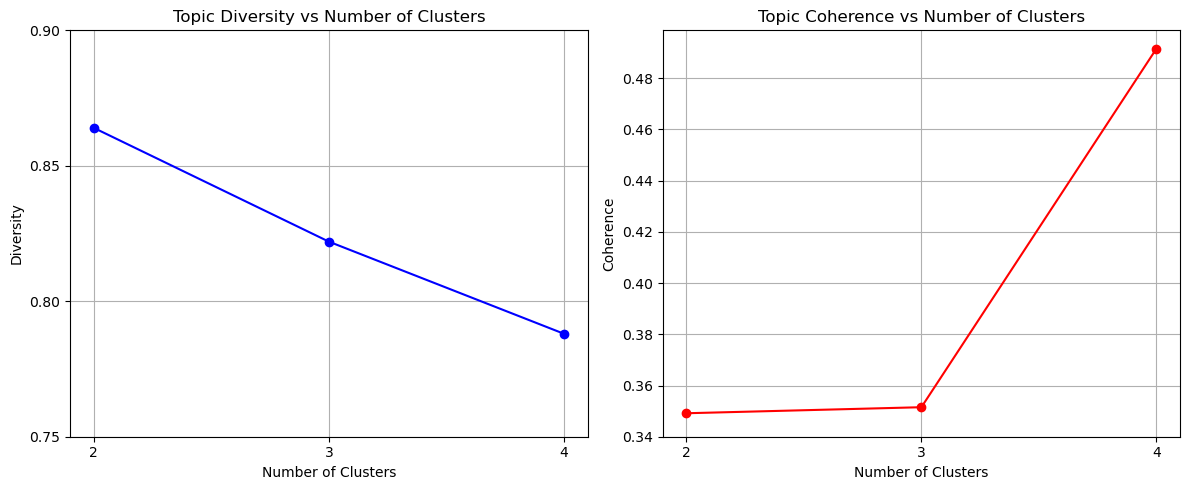

In [10]:
# 绘制图表
plot_results(results)

In [11]:
def cluster_analysis_compare(G, embeddings, nodes, n_clusters_range):
    results = []
    clusters_range = []
    
    # 筛选种子节点
    seed_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'seed']
    seed_indices = [nodes.index(n) for n in seed_nodes]
    seed_embeddings = embeddings[seed_indices]
    
    # UMAP降维
    umap = UMAP(n_components=2, random_state=42)
    umap_embeddings = umap.fit_transform(seed_embeddings)

    # 将数据映射到均匀分布
    quantile = QuantileTransformer(output_distribution='uniform')
    normalized_emb = quantile.fit_transform(umap_embeddings)
    
    for n_clusters in n_clusters_range:
        print(f"Processing {n_clusters} clusters...")
        
        # 聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(normalized_emb)
        clusters_range.append(clusters)
        
        # 提取每个聚类的主题词
        cluster_topics_words, cluster_topics_ctfidfs = extract_top_words_ctfidf_from_clusters(G, seed_nodes, clusters)
        topics_words = list(cluster_topics_words.values())
        topics_ctfidfs = list(cluster_topics_ctfidfs.values())
        
        # 计算指标
        diversity = calculate_topic_diversity(topics_words)
        coherence, coherences = calculate_topic_coherence(G, seed_nodes, topics_words)
        
        # 保存结果
        results.append({
            'n_clusters': n_clusters,
            'diversity': diversity,
            'coherence': coherence,
            'cohenrences': coherences,
            'topics_words': topics_words,
            'topic_ctfidfs': topics_ctfidfs
        })
    
    return G, results

def plot_results_compare(results, results_c, best_row=None):
    """绘制结果图表"""
    n_clusters = [r['n_clusters'] for r in results]
    diversities = [r['diversity'] for r in results]
    coherences = [r['coherence'] for r in results]
    diversities_c = [r['diversity'] for r in results_c]
    coherences_c = [r['coherence'] for r in results_c]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_clusters, diversities, 'bo-', label='w DGCN')
    plt.plot(n_clusters, diversities_c, 'b-', alpha=0.2, label='w/o DGCN')
    if best_row is not None:
        plt.scatter(best_row['n_clusters'], best_row['diversity'], c='gold', marker='*', s=200, zorder=4)
    plt.title('Topic Diversity vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.xticks([n['n_clusters'] for n in results])
    plt.ylabel('Diversity')
    # 设置 y 轴刻度，从最小值到最大值，每隔 0.05 一个刻度
    y_min = np.floor(min(min(diversities), min(diversities_c)) * 20) / 20  # 向下取整到最近的 0.05
    y_max = np.ceil(max(max(diversities), max(diversities_c)) * 20) / 20    # 向上取整到最近的 0.05
    plt.yticks(np.arange(y_min, y_max, 0.05))  # 生成 0.05 间隔的刻度
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_clusters, coherences, 'ro-', label='w DGCN')
    plt.plot(n_clusters, coherences_c, 'r-', alpha=0.2, label='w/o DGCN')
    if best_row is not None:
        plt.scatter(best_row['n_clusters'], best_row['coherence'], c='gold', marker='*', s=200, zorder=4)
    plt.title('Topic Coherence vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.xticks([n['n_clusters'] for n in results])
    plt.ylabel('Coherence')
    # 设置 y 轴刻度，从最小值到最大值，每隔 0.02 一个刻度
    y_min = np.floor(min(min(coherences), min(coherences_c)) * 50) / 50  # 向下取整到最近的 0.02
    y_max = np.ceil(max(max(coherences), max(coherences_c)) * 50) / 50    # 向上取整到最近的 0.02
    plt.yticks(np.arange(y_min, y_max, 0.02))  # 生成 0.02 间隔的刻度
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [12]:
import warnings

warnings.filterwarnings("ignore")  # 忽略所有警告

# 运行分析
G_c, results_c = cluster_analysis_compare(G, X.numpy(), nodes, n_clusters_range)

# 将结果保存为DataFrame
results_df_c = pd.DataFrame(results_c)

# 保存结果到CSV
results_df_c.to_csv('dgcn_compare_clustering_results_2018.csv', index=False)
print("结果已保存到 dgcn_compare_clustering_results_2018.csv")

warnings.resetwarnings()  # 重置为Python默认的警告行为

Processing 2 clusters...
Processing 3 clusters...
Processing 4 clusters...
结果已保存到 dgcn_compare_clustering_results_2018.csv


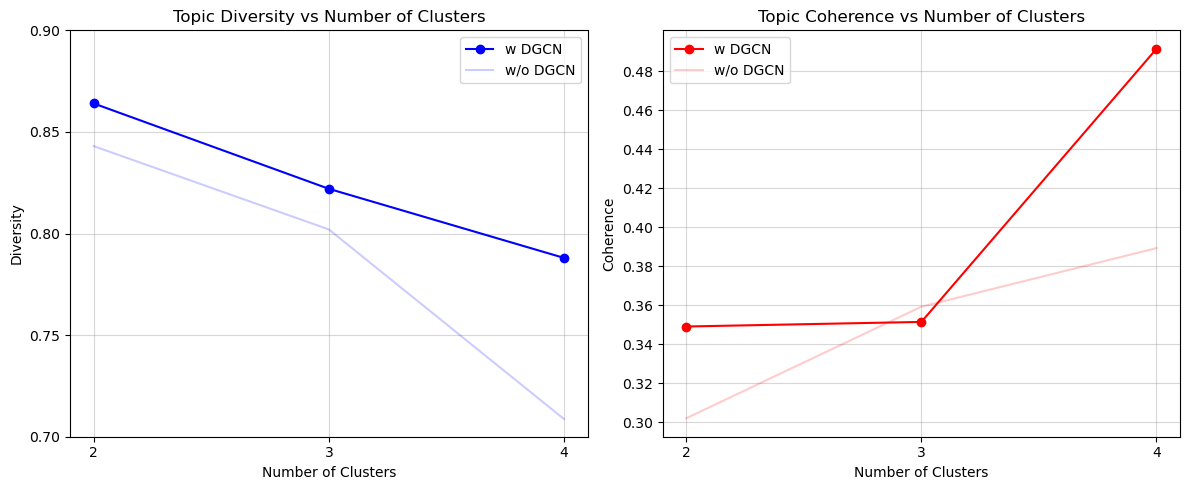

In [13]:
# 绘制图表
plot_results_compare(results, results_c)

In [14]:
def calculate_best_n(results_df, results_df_c):
    avg_coh = results_df.coherence.mean()
    results_df['diff_coh'] = [coherence - results_df_c.coherence[i] for i, coherence in enumerate(results_df.coherence)]
    results = results_df.sort_values(by=['diff_coh', 'coherence'], ascending=[False, False])

    best_n = None
    for coh in results.coherence:
        if coh >= avg_coh:
            best_n = results_df.index[results_df.coherence == coh][0]
            best_row = results_df.iloc[best_n]
            # 打印最佳结果
            print(f"最佳聚类数: {best_row['n_clusters']}")
            print(f"多样性: {best_row['diversity']:.4f}")
            print(f"一致性: {best_row['coherence']:.4f}")
            return best_n
        
    return 'Error!'

def update_graph(G, clusters_range, best_n):
    seed_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'seed']

    for i, node in enumerate(seed_nodes):
        G.nodes[node]['cluster'] = int(clusters_range[best_n][i])
    
    print('Graph updated!')
    return G



In [15]:
best_n = calculate_best_n(results_df, results_df_c)

G = update_graph(G, clusters_range, best_n)

最佳聚类数: 4
多样性: 0.7880
一致性: 0.4916
Graph updated!


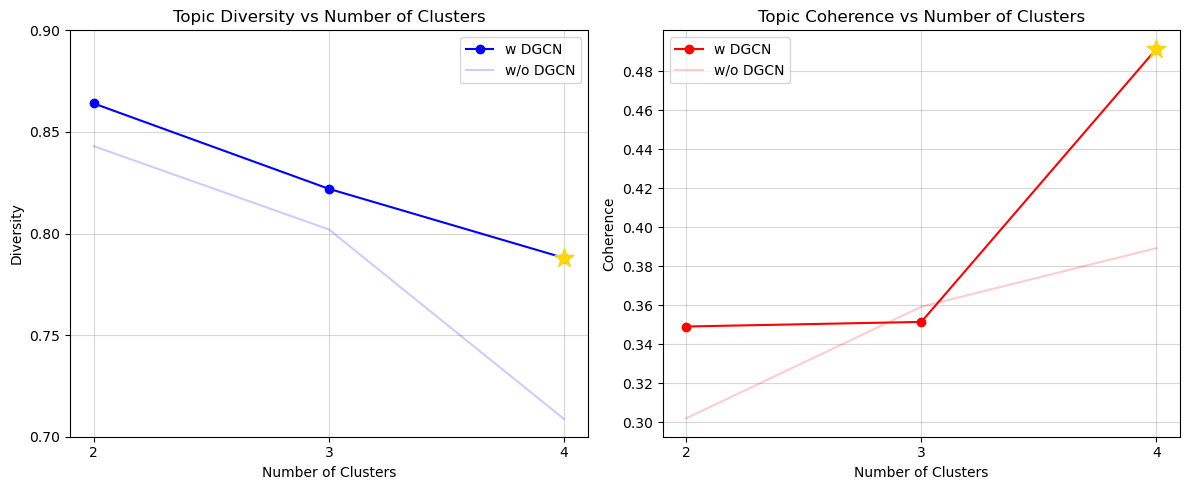

In [16]:
# 绘制图表
plot_results_compare(results, results_c, best_row=results_df.iloc[best_n])

In [17]:
# 保存结果
with open('dgcn_result_2018.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Pipeline completed!")

Pipeline completed!


5. 可视化

In [18]:
import matplotlib.pyplot as plt
import colorsys

def visualize_results(G, d):
    seed_nodes = [n for n in G.nodes() if G.nodes[n].get('type') == 'seed']
    if not seed_nodes:
        print("No seed nodes found!")
        return
    
    clusters = [G.nodes[n]['cluster'] for n in seed_nodes]
    coords = np.array([G.nodes[n]['umap'] for n in seed_nodes])

    rgb_colors = [
    colorsys.hls_to_rgb(h=(cluster * d % 360) / 360, l=0.5, s=1.0)  # HLS → RGB
    for cluster in clusters
    ]
    
    plt.figure(figsize=(12, 12))
    plt.scatter(coords[:, 0], coords[:, 1], c=rgb_colors, alpha=0.7, s=100)
    
    # 标注部分节点
    for i, node in enumerate(seed_nodes): 
        plt.annotate(G.nodes[node]['title'][:15] + "...", 
                    (coords[i, 0], coords[i, 1]),
                    fontsize=8, alpha=0.8)
    
    #plt.colorbar(scatter, label='Cluster')
    plt.title("Seed Papers Clustering in UMAP Space")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

Visualizing results...


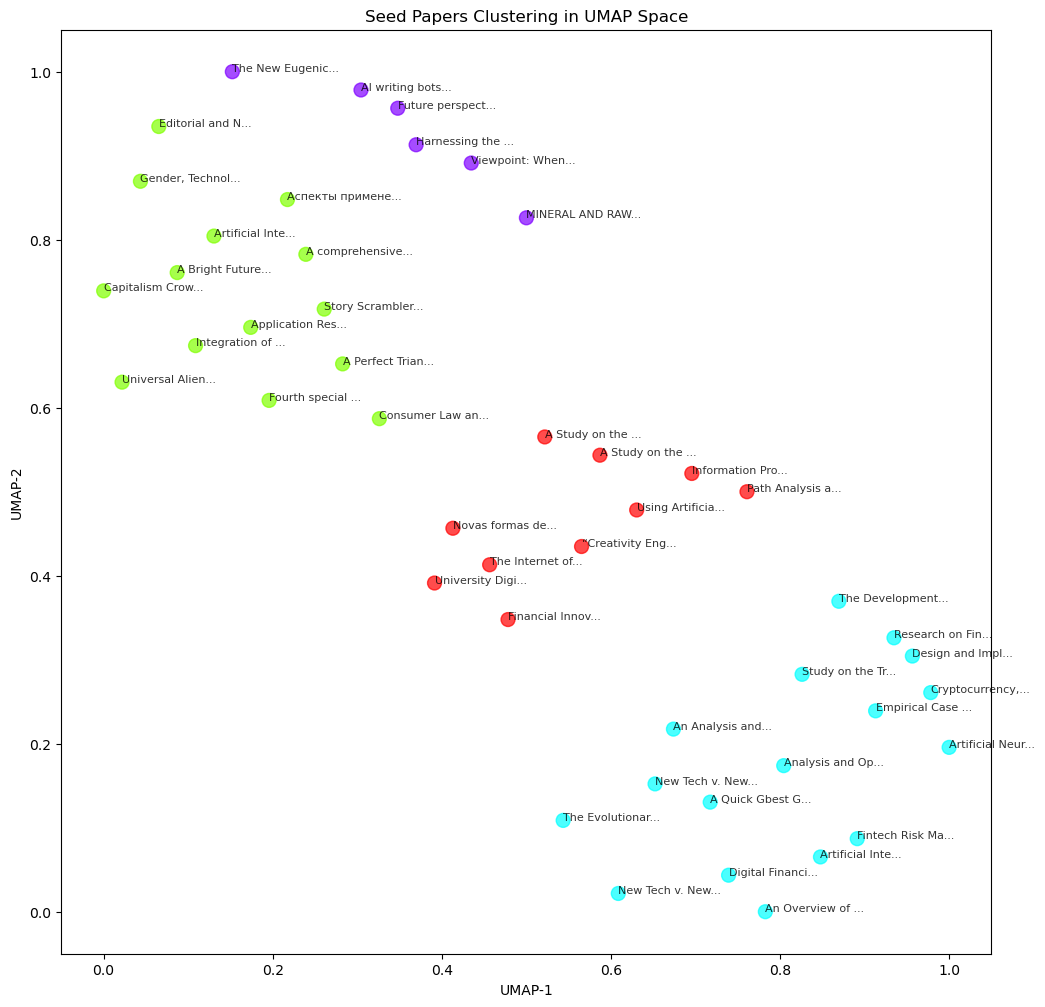

In [19]:
print("Visualizing results...")
visualize_results(G, 360//results_df.n_clusters[best_n])

### 关键功能说明：
#### 1.数据准备：
- 标准化节点特征
- 构建入度/出度邻接矩阵
- 转换为PyTorch稀疏张量

#### 2.DGCN模型：
- 分别处理入度和出度传播
- 两层图卷积结构
- 输出拼接的双向信息

#### 3.训练过程：
- 随机游走对比损失
- 梯度裁剪(max_norm=5.0)
- 早停机制(patience=20)

#### 4.种子节点处理：
- 自动确定最佳聚类数(肘部法则)
- UMAP降维到2D空间
- K-means聚类

#### 5.可视化：
- 带聚类的2D散点图
- 标注部分论文标题
- 使用tab20色系区分簇

### 使用说明：
#### 1.确保您的NetworkX图G包含：
- 节点属性bert_vector(文本向量)
- 节点属性type(标注种子/参考文献/被引文献)
- 节点属性title(用于可视化标注)

#### 2.运行main_pipeline(G)将执行完整流程

#### 3.结果将保存到:
- best_dgcn_model.pt: 训练好的模型
- dgcn_results.pkl: 包含聚类结果的图对象

#### 4.可视化将显示种子论文在UMAP空间的聚类情况